# Proyecto Narración de partidos de Futbol

In [15]:
import re
import unicodedata
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import seaborn as sns
import math

## Los Datos

In [5]:
data = pd.read_excel('Data_Partidosxlsx.xlsx')
df = data.drop(columns=["|", "Video URL"])
df.head()

Subtitles  tar_ama_1  tar_ama_2  \
0  WEBVTT Kind: captions Language: es entramos en...        3.0        4.0   
1  WEBVTT Kind: captions Language: es rojas n√∫me...        0.0        2.0   
2  WEBVTT Kind: captions Language: es Bueno amigo...        1.0        1.0   
3  WEBVTT Kind: captions Language: es [Aplausos] ...        1.0        1.0   
4  WEBVTT Kind: captions Language: es I que va ae...        1.0        7.0   

   tar_roj_1  tar_roj_2  tiros_esquina_1  tiros_esquina_2  gol_1  gol_2  \
0        0.0        1.0              5.0              3.0    4.0    1.0   
1        0.0        0.0              NaN              NaN    3.0    1.0   
2        0.0        0.0             13.0              3.0    0.0    2.0   
3        0.0        0.0              NaN              NaN    2.0    0.0   
4        1.0        1.0              5.0              6.0    2.0    2.0   

   atajadas_1  ...  posesion_1  posesion_2  faltas_1  faltas_2  tiros_1  \
0         3.0  ...       0.547       0.453      14.0      18.0     19.0   
1         NaN  ...         NaN         NaN       NaN       NaN      NaN   
2         4.0  ...       0.570       0.430      21.0      19.0     11.0   
3         NaN  ...         NaN         NaN       NaN       NaN      NaN   
4         NaN  ...       0.450       0.550      19.0      25.0     16.0   

   tiros_2  penales_1  penales_2  penales_final_1  penales_final_2  
0     14.0        0.0        0.0              0.0              0.0  
1      NaN        0.0        0.0              0.0              0.0  
2      9.0        0.0        0.0              0.0              0.0  
3      NaN        0.0        0.0              0.0              0.0  
4     12.0        1.0        0.0              0.0              0.0  

[5 rows x 21 columns]

In [6]:
for col in df:
    porcentaje = df[col].isnull().mean()
    if (porcentaje > 0):
        print(f'{col}: {porcentaje}')

tar_ama_1: 0.46062992125984253
tar_ama_2: 0.46062992125984253
tar_roj_1: 0.46062992125984253
tar_roj_2: 0.46062992125984253
tiros_esquina_1: 0.5078740157480315
tiros_esquina_2: 0.5078740157480315
gol_1: 0.46062992125984253
gol_2: 0.4566929133858268
atajadas_1: 0.5393700787401575
atajadas_2: 0.5433070866141733
posesion_1: 0.5
posesion_2: 0.5
faltas_1: 0.531496062992126
faltas_2: 0.531496062992126
tiros_1: 0.5354330708661418
tiros_2: 0.5354330708661418
penales_1: 0.47244094488188976
penales_2: 0.47244094488188976
penales_final_1: 0.47244094488188976
penales_final_2: 0.47244094488188976


In [7]:
df.dropna(inplace=True)

In [8]:
Y = df.drop(columns="Subtitles")
X = df["Subtitles"]
X.shape, Y.shape

((114,), (114, 20))

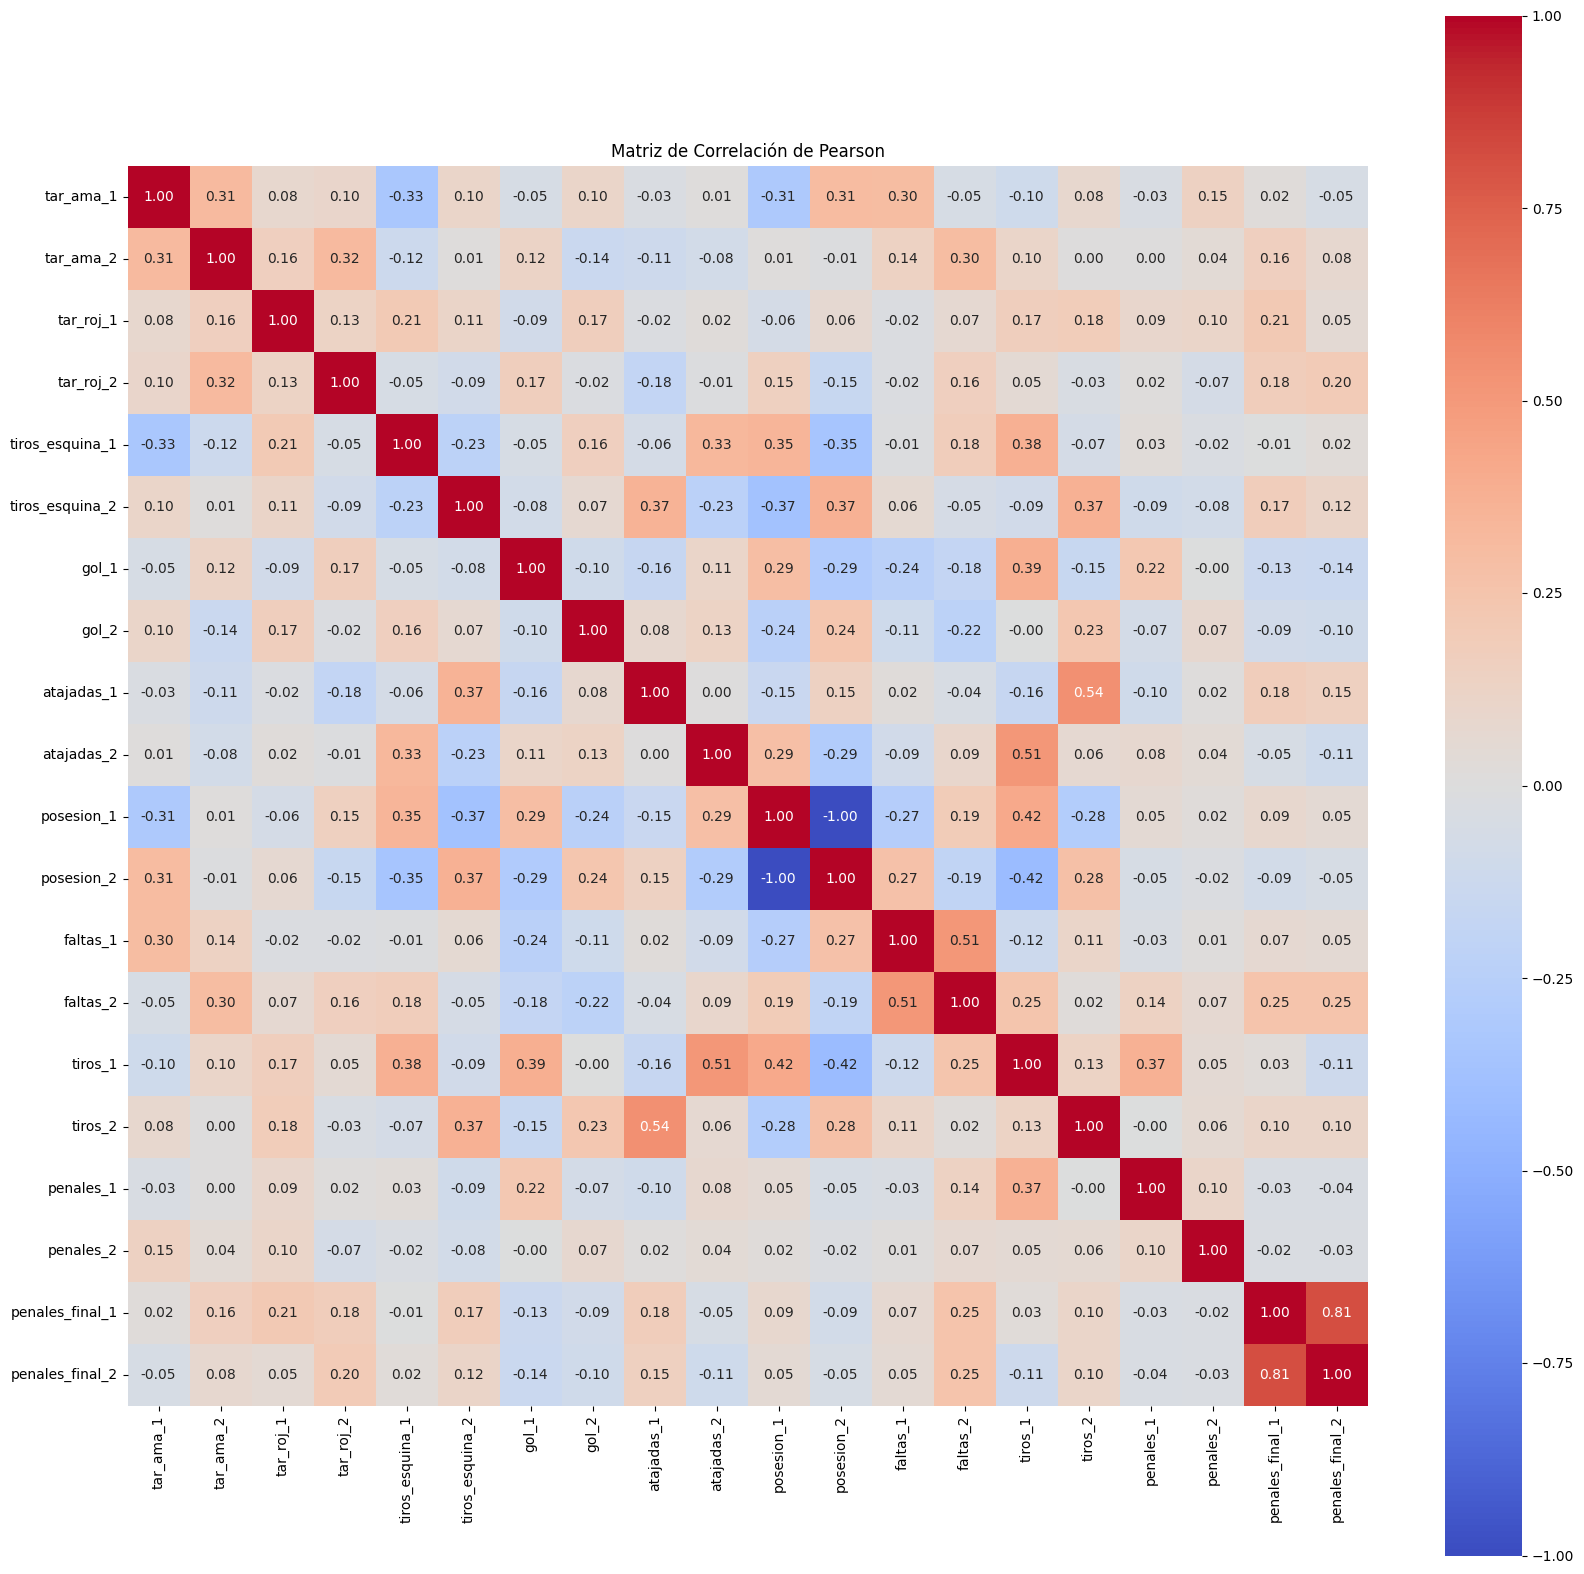

In [12]:
correlation_matrix = Y.corr(method='pearson')

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de Correlación de Pearson")
plt.show()


coolineales = np.where((abs(correlation_matrix) > 0.2) & (correlation_matrix != 1))

In [13]:
coolineales = np.array(coolineales).T
temp = []
j = 0
for i in coolineales:

    pasar = True
    for k in temp:
        if((i[0] == k[1]) & (i[1] == k[0])):
            pasar = False
    if(pasar):
        temp.insert(j, i)
        j = j + 1

coolineales = temp
coolineales = np.array(coolineales).transpose()
coolineales

array([[ 0,  0,  0,  0,  0,  1,  1,  2,  2,  4,  4,  4,  4,  4,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  8,  9,  9,  9,
        10, 10, 10, 10, 11, 11, 11, 12, 13, 13, 13, 14, 18],
       [ 1,  4, 10, 11, 12,  3, 13,  4, 18,  5,  9, 10, 11, 14,  8,  9,
        10, 11, 15, 10, 11, 12, 14, 16, 10, 11, 13, 15, 15, 10, 11, 14,
        11, 12, 14, 15, 12, 14, 15, 13, 14, 18, 19, 16, 19]])

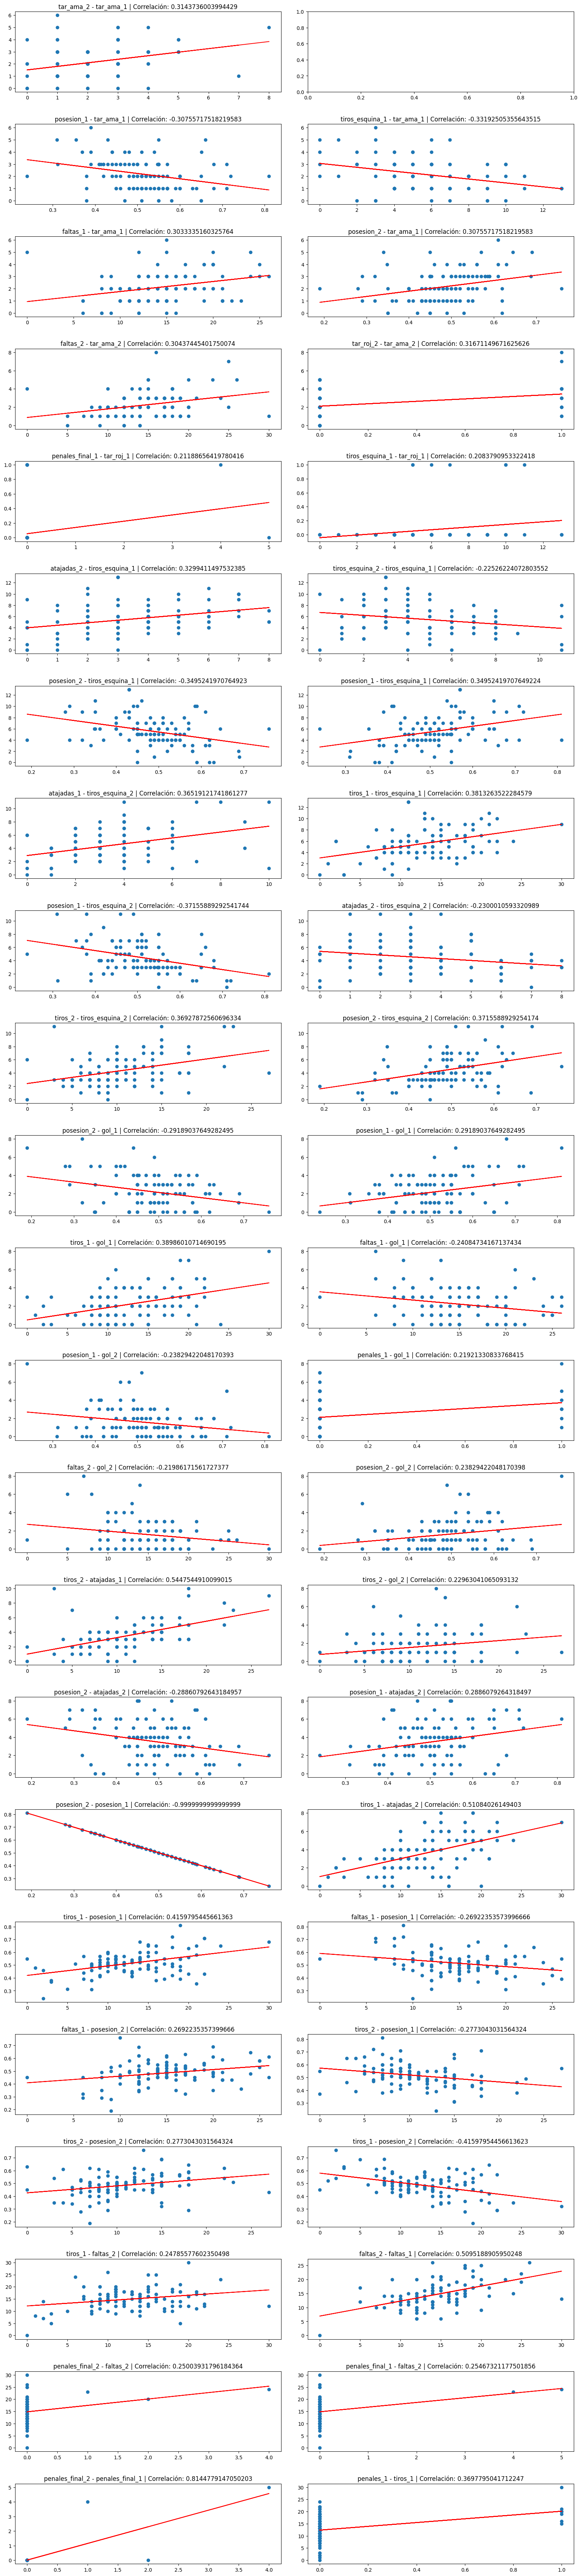

In [16]:
def corr_lineal(df):
  i = 0
  j = 0
  n = 2
  umbral = 0.50
  columnas = math.ceil(coolineales[0].size/n)
  #plt.figure(figsize=(12, 15))
  fig, axes = plt.subplots(columnas, n, figsize=(20, columnas*4))
  for k in range(coolineales[0].size):
      col = coolineales[0][k]
      ind = coolineales[1][k]

      x = df[correlation_matrix.index[ind]]
      y = df[correlation_matrix.columns[col]]

      # Filtrar nulos de ambas series (x, y)
      mask = x.notnull() & y.notnull()
      x_filtered = x[mask]
      y_filtered = y[mask]

      # Cálculos con los datos filtrados
      temp = np.corrcoef(x_filtered, y_filtered)[0][1]

      # Gráfica con los datos filtrados
      axes[i % columnas, j % n].scatter(x_filtered, y_filtered)

      # Ajuste de la línea con los datos filtrados
      coef = np.polyfit(x_filtered, y_filtered, 1)
      poly1d_fn = np.poly1d(coef)

      axes[i % columnas, j % n].plot(x, poly1d_fn(x), color="red")

      titulo = str(correlation_matrix.index[ind]) + " - " + str(correlation_matrix.columns[col]) + " | Correlación: " + str(temp)
      axes[i % columnas, j % n].set_title(titulo)

      j = j + 1
      if j % n == 1:
          i = i + 1

  plt.subplots_adjust(wspace=0.1, hspace=0.4)
  plt.show()
corr_lineal(Y)

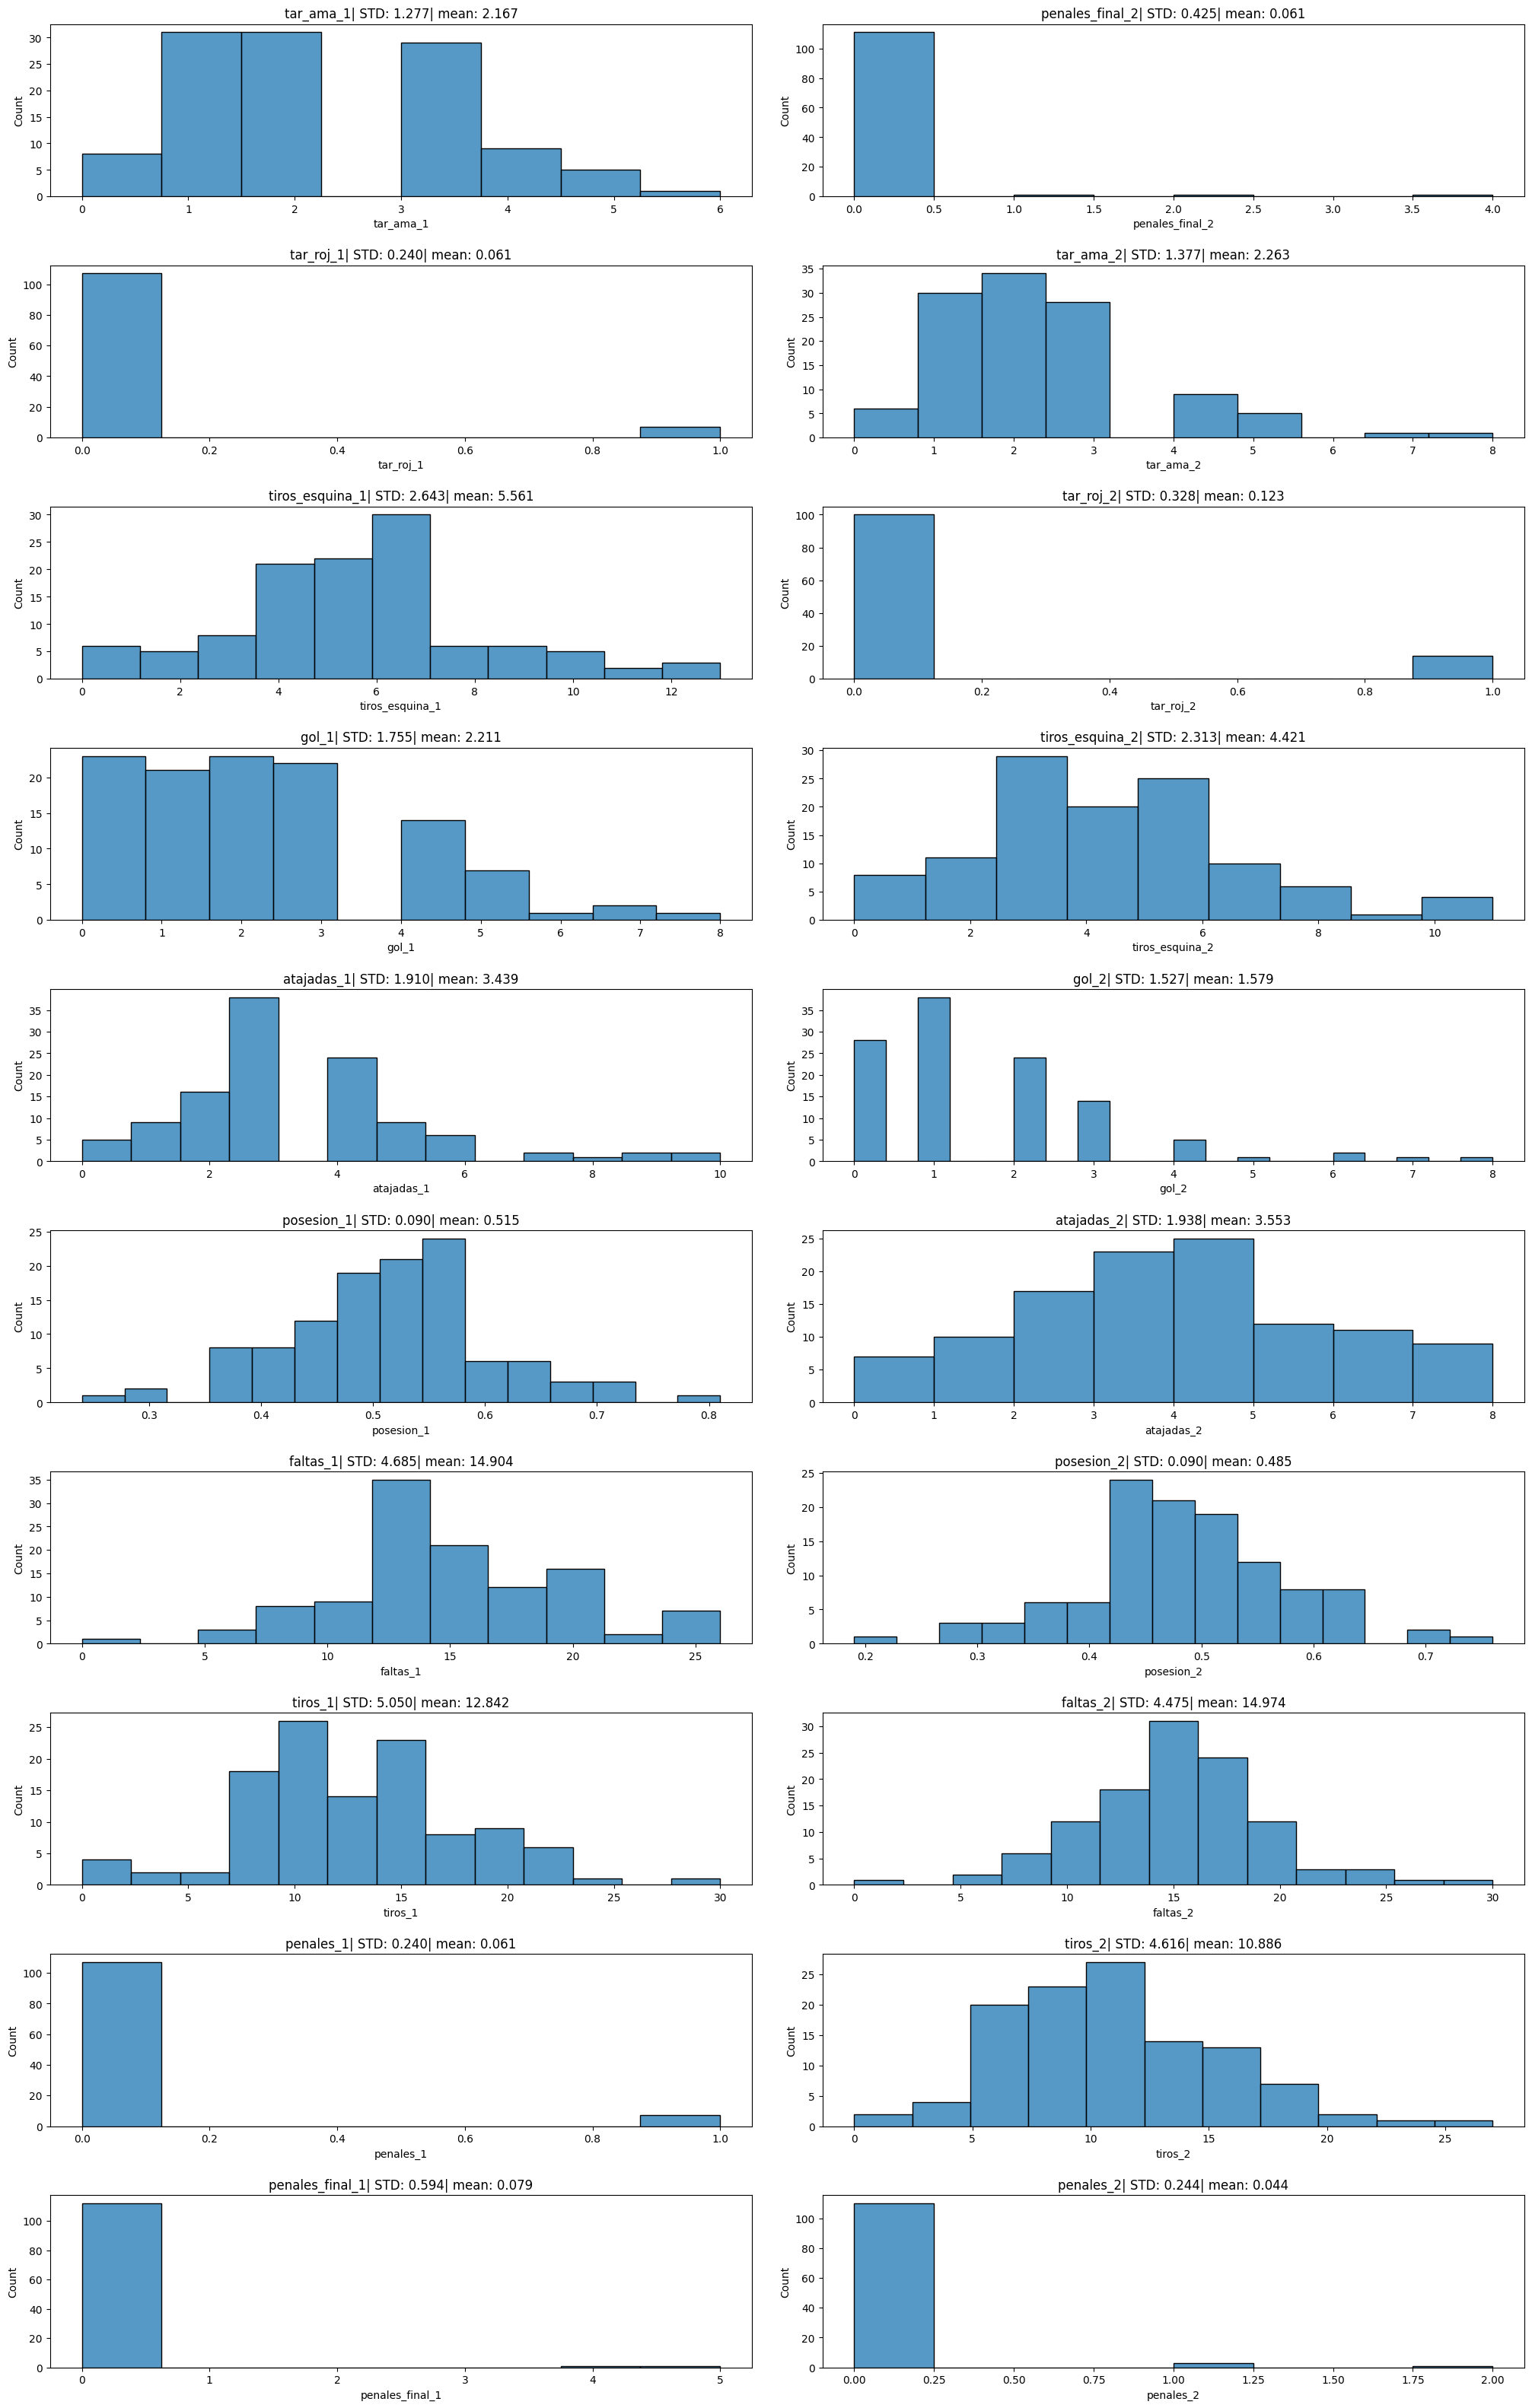

In [17]:
def distrubucion_var(df):
  i = 0
  j = 0
  n = 2
  umbral = 0.75
  columnas = math.ceil(df.columns.size/n)
  #plt.figure(figsize=(12, 15))
  fig, axes = plt.subplots(columnas, n, figsize=(25, 4*columnas))

  for col in df:
      sns.histplot(df[col], kde=False, ax=axes[i%columnas, j%n])
      titulo = f"{col}| STD: {np.std(df[col]):.3f}| mean: {np.mean(df[col]):.3f}"
      axes[i%columnas, j%n].set_title(titulo)

      j = j + 1
      if(j%n == 1) : i = i + 1

  plt.subplots_adjust(wspace=0.1, hspace=0.4)
  plt.show()
distrubucion_var(Y)

In [18]:
X = pd.DataFrame(X)
X

Subtitles
0    WEBVTT Kind: captions Language: es entramos en...
2    WEBVTT Kind: captions Language: es Bueno amigo...
5    WEBVTT Kind: captions Language: es de 2006, la...
6    WEBVTT Kind: captions Language: es [Aplausos] ...
9    WEBVTT Kind: captions Language: es frente a la...
..                                                 ...
247  qué tal Cómo estáis Espero que bien  Bienvenid...
248  [Aplausos]  Saludos bienvenidos amigos del  es...
250  bajo la lluvia Real Sociedad Fútbol Club  Barc...
252  [Música]  qué tal amigos saludos bienvenidos a...
253  saludos bienvenidos a la liga bbva  bienvenido...

[114 rows x 1 columns]

### Visualización de WordCloud

In [20]:
from wordcloud import WordCloud, STOPWORDS

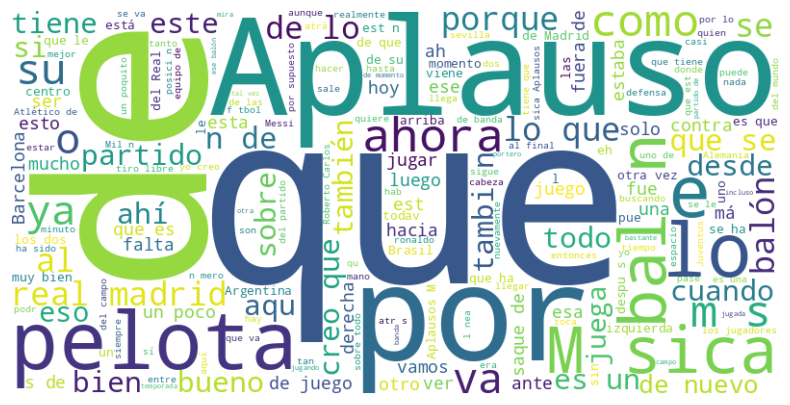

In [23]:
narraciones = ' '.join(X.iloc[:, 0].astype(str))
stopwords = set(STOPWORDS)
stopwords.update(["y", "en", "el", "la", "para", "pero", "con"])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords = stopwords).generate(narraciones)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Quitar los ejes
plt.show()

### Simplificar el dataset

In [24]:
import nltk
import spacy
from nltk.stem import SnowballStemmer

In [27]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 70.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [28]:

# Función para limpiar los subtítulos eliminando metadatos y normalizando los caracteres
def clean_subtitles(text):
    text = re.sub(r'WEBVTT.*Language:', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\d{2}:\d{2}:\d{2}.\d{3} --> \d{2}:\d{2}:\d{2}.\d{3}', '', text)

    # Reemplazar tildes y mantener la ñ
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')

    # Convertimos letras acentuadas a letras normales (a, e, i, o, u)
    text = re.sub(r'á', 'a', text)
    text = re.sub(r'é', 'e', text)
    text = re.sub(r'í', 'i', text)
    text = re.sub(r'ó', 'o', text)
    text = re.sub(r'ú', 'u', text)

    # Eliminar espacios adicionales
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicar la limpieza al dataset
df['Cleaned_Subtitles'] = df['Subtitles'].apply(clean_subtitles)

In [29]:
# Descargar recursos de NLTK
nltk.download('punkt')

# Cargar el modelo de spaCy para lematización en español
nlp = spacy.load('es_core_news_sm')

# Crear el stemmer para español
stemmer = SnowballStemmer('spanish')

# Función para aplicar stemming
def stemming(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Función para aplicar lematización
def lemmatization(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

# Aplicar stemming
df['stemmed_Subtitles'] = df['Cleaned_Subtitles'].apply(stemming)

# Aplicar lematización después del stemming
df['lemmatized_Subtitles'] = df['stemmed_Subtitles'].apply(lemmatization)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
df.head()

Subtitles  tar_ama_1  tar_ama_2  \
0  WEBVTT Kind: captions Language: es entramos en...        3.0        4.0   
2  WEBVTT Kind: captions Language: es Bueno amigo...        1.0        1.0   
5  WEBVTT Kind: captions Language: es de 2006, la...        1.0        3.0   
6  WEBVTT Kind: captions Language: es [Aplausos] ...        4.0        3.0   
9  WEBVTT Kind: captions Language: es frente a la...        4.0        3.0   

   tar_roj_1  tar_roj_2  tiros_esquina_1  tiros_esquina_2  gol_1  gol_2  \
0        0.0        1.0              5.0              3.0    4.0    1.0   
2        0.0        0.0             13.0              3.0    0.0    2.0   
5        0.0        1.0              5.0              7.0    1.0    1.0   
6        0.0        0.0              5.0              7.0    0.0    1.0   
9        0.0        0.0              5.0              3.0    1.0    3.0   

   atajadas_1  ...  faltas_2  tiros_1  tiros_2  penales_1  penales_2  \
0         3.0  ...      18.0     19.0     14.0        0.0        0.0   
2         4.0  ...      19.0     11.0      9.0        0.0        0.0   
5         6.0  ...      24.0      6.0     14.0        0.0        0.0   
6         5.0  ...      17.0     13.0     15.0        0.0        0.0   
9         3.0  ...      15.0      9.0     11.0        0.0        0.0   

   penales_final_1  penales_final_2  \
0              0.0              0.0   
2              0.0              0.0   
5              5.0              4.0   
6              0.0              0.0   
9              0.0              0.0   

                                   Cleaned_Subtitles  \
0  es entramos en el santeo bernabeu donde como v...   
2  es Bueno amigos de la Rede Globo, hoy es para ...   
5  es de 2006, la final nmero 18 desde la primera...   
6  es as= que dignidades de la realeza pol=ticos ...   
9  es frente a la roma con la concepcin del gol q...   

                                   stemmed_Subtitles  \
0  es entram en el sante bernabeu dond com ven se...   
2  es buen amig de la red glob , hoy es par val b...   
5  es de 2006 , la final nmer 18 desd la primer q...   
6  es as= que dignidad de la realez pol=tic tod q...   
9  es frent a la rom con la concepcin del gol que...   

                                lemmatized_Subtitles  
0  ser entram en el sante bernabeu dond com ver é...  
2  ser buen amig de el red glob , hoy ser par val...  
5  ser de 2006 , el final nmer 18 desd el primero...  
6  ser as= que dignidad de el realez pol = tic to...  
9  ser frent a el rom con el concepcin del gol qu...  

[5 rows x 24 columns]

In [31]:
# Definir los patrones de eventos clave utilizando expresiones regulares
event_patterns = {
    'Goles': r'\b(gol|anotacion|marco|marcaron)\b',
    'Tarjetas Amarillas': r'\b(tarjeta amarilla|amonestacion|amarilla)\b',
    'Tarjetas Rojas': r'\b(tarjeta roja|expulsado|expulsion|expulsar|roja|expulsaron|se va| expulsado)\b',
    'Tiros de Esquina': r'\b(corner|tiro de esquina)\b',
    'Saques de Banda': r'\b(saque de banda)\b',
    'Faltas': r'\b(falta|infraccion|foul|faul)\b',
    'Penales': r'\b(penal|penalty)\b',
    'Posesión de balón': r'\b(posesion)\b',
    'Fueras de juego': r'\b(fuera de juego|offside|adelantado)\b',
    'Tiros': r'\b(tiro|disparo)\b'
}

# Función para etiquetar un fragmento de texto con el evento correspondiente
def label_events(text):
    labels = []
    for event, pattern in event_patterns.items():
        if re.search(pattern, text, re.IGNORECASE):
            labels.append(event)
    return labels

# Aplicar la función para generar etiquetas
df['Event_Labels'] = df['lemmatized_Subtitles'].apply(label_events)

# Convertir las listas de eventos en una única etiqueta simplificada por fragmento
def simplify_labels(event_list):
    if 'Goles' in event_list:
        return 0  # Goles
    elif 'Tarjetas Amarillas' in event_list:
        return 1  # Tarjeta Amarilla
    elif 'Tarjetas Rojas' in event_list:
        return 2  # Tarjeta Roja
    elif 'Tiros de Esquina' in event_list:
        return 3  # Tiros de Esquina
    elif 'Faltas' in event_list:
        return 4  # Faltas
    elif 'Penales' in event_list:
        return 5  # Penales
    else:
        return 6  # Ningún evento

df['Simplified_Labels'] = df['Event_Labels'].apply(simplify_labels)

# Función para detectar eventos en un fragmento de texto
def detect_events(text):
    event_counts = {event: 0 for event in event_patterns}  # Inicializamos el conteo de eventos
    for event, pattern in event_patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        event_counts[event] += len(matches)  # Contamos cuántas veces aparece cada evento
    return event_counts

## LSTM base con lematización

In [33]:
# Dividimos los datos en entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Aumentamos el tamaño máximo de secuencias para capturar más contexto
maxlen = 200  # Aumentamos el tamaño máximo de la secuencia para capturar más contexto

# Tokenización del texto
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['lemmatized_Subtitles'])

train_sequences = tokenizer.texts_to_sequences(train_data['lemmatized_Subtitles'])
test_sequences = tokenizer.texts_to_sequences(test_data['lemmatized_Subtitles'])

# Rellenamos las secuencias para que tengan la misma longitud
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_test = pad_sequences(test_sequences, maxlen=maxlen)

# Convertimos las etiquetas en arrays
y_train = train_data['Simplified_Labels']
y_test = test_data['Simplified_Labels']

# Definimos el modelo LSTM con dropout
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
    tf.keras.layers.LSTM(256, return_sequences=False),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout después de la LSTM
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),  # Añadimos dropout antes de la capa final
    tf.keras.layers.Dense(7, activation='softmax')  # 7 clases de eventos
])

# Compilamos el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definimos EarlyStopping para detener el entrenamiento cuando el modelo deja de mejorar
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamos el modelo con más épocas y early stopping
history = model.fit(X_train, y_train,
                    epochs=300,  # Aumentamos las épocas
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 867ms/step - accuracy: 0.3708 - loss: 1.9378 - val_accuracy: 0.9565 - val_loss: 1.8564
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 714ms/step - accuracy: 0.9773 - loss: 1.7790 - val_accuracy: 0.9565 - val_loss: 0.5879
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 835ms/step - accuracy: 0.9890 - loss: 0.3939 - val_accuracy: 0.9565 - val_loss: 0.3078
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9851 - loss: 0.1154 - val_accuracy: 0.9565 - val_loss: 0.3052
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 706ms/step - accuracy: 0.9656 - loss: 0.2341 - val_accuracy: 0.9565 - val_loss: 0.2391
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step - accuracy: 0.9734 - loss: 0.1480 - val_accuracy: 0.9565 - val_loss: 0.2057
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step - accuracy: 0.9734 - loss: 0.1787 - val_accuracy: 0.9565 - val_loss: 0.1954
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9656 - loss: 0.2054 - val_accuracy: 0.9565 - val_los

In [34]:
# Función para convertir predicciones de modelos en eventos legibles
def prediction_to_event(pred):
    event_index = np.argmax(pred)
    event_mapping = {0: 'Goles', 1: 'Tarjetas Amarillas', 2: 'Tarjetas Rojas', 3: 'Tiros de Esquina', 4: 'Faltas', 5: 'Penales', 6: 'Ningún evento'}
    return event_mapping[event_index]

# Aplicamos el modelo a nuevas narraciones
predictions = model.predict(X_test)

# Función mejorada para asignar los eventos detectados a Equipo 1 y Equipo 2
def assign_events_to_teams(text, team1_name='Equipo 1', team2_name='Equipo 2'):
    team1_stats = {event: 0 for event in event_patterns}
    team2_stats = {event: 0 for event in event_patterns}

    # Procesamos el texto en oraciones o fragmentos
    sentences = text.split('.')

    # Alternamos entre los equipos para asignar los eventos
    current_team = 1

    for sentence in sentences:
        event_counts = detect_events(sentence)

        # Asignar los eventos al equipo correspondiente
        if current_team == 1:
            for event, count in event_counts.items():
                team1_stats[event] += count
            current_team = 2  # Alternamos al Equipo 2
        else:
            for event, count in event_counts.items():
                team2_stats[event] += count
            current_team = 1  # Volvemos al Equipo 1

    return team1_stats, team2_stats

# Crear listas para almacenar las estadísticas y predicciones
matches_stats = []

# Generar estadísticas para todas las narraciones de prueba
for i in range(len(test_data)):  # Recorremos todas las narraciones
    narration = test_data['Cleaned_Subtitles'].iloc[i]
    event_prediction = prediction_to_event(predictions[i])
    team1_stats, team2_stats = assign_events_to_teams(narration)

    # Crear un diccionario con los datos de la narración actual
    match_stats = {
        'Narration': narration,
        'Predicted_Event': event_prediction,
        'Team1_Stats': team1_stats,
        'Team2_Stats': team2_stats
    }

    # Agregar el diccionario a la lista
    matches_stats.append(match_stats)

# Convertir la lista de diccionarios en un DataFrame
df_matches_stats = pd.DataFrame(matches_stats)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


In [36]:
df_matches_stats.head()

Narration Predicted_Event  \
0  les recuerdo siempre para el gran Diego Armand...           Goles   
1  es frente a la roma con la concepcin del gol q...           Goles   
2  es el estadio azteca inundado de color una atm...           Goles   
3  hola saludos a todos bienvenidos al clasico ma...           Goles   
4  es seoras y seores muy buenas noches desde el ...           Goles   

                                         Team1_Stats  \
0  {'Goles': 9, 'Tarjetas Amarillas': 1, 'Tarjeta...   
1  {'Goles': 13, 'Tarjetas Amarillas': 0, 'Tarjet...   
2  {'Goles': 8, 'Tarjetas Amarillas': 0, 'Tarjeta...   
3  {'Goles': 0, 'Tarjetas Amarillas': 0, 'Tarjeta...   
4  {'Goles': 6, 'Tarjetas Amarillas': 1, 'Tarjeta...   

                                         Team2_Stats  
0  {'Goles': 0, 'Tarjetas Amarillas': 0, 'Tarjeta...  
1  {'Goles': 0, 'Tarjetas Amarillas': 0, 'Tarjeta...  
2  {'Goles': 11, 'Tarjetas Amarillas': 0, 'Tarjet...  
3  {'Goles': 2, 'Tarjetas Amarillas': 2, 'Tarjeta...  
4  {'Goles': 0, 'Tarjetas Amarillas': 1, 'Tarjeta...

In [59]:
team1_stats_list = df_matches_stats['Team1_Stats']
team2_stats_list = df_matches_stats['Team2_Stats']

# Crear dataframes separados para Team1_Stats y Team2_Stats
df_team1 = pd.DataFrame(team1_stats_list.tolist()).rename(columns={
    'Tarjetas Amarillas': 'tar_ama_1',
    'Tarjetas Rojas': 'tar_roj_1',
    'Tiros de Esquina': 'tiros_esquina_1',
    'Goles': 'gol_1',
    'Atajadas': 'atajadas_1',
    'Posesión de balón': 'posesion_1',
    'Faltas': 'faltas_1',
    'Tiros': 'tiros_1',
    'Penales': 'penales_1'
})

df_team2 = pd.DataFrame(team2_stats_list.tolist()).rename(columns={
    'Tarjetas Amarillas': 'tar_ama_2',
    'Tarjetas Rojas': 'tar_roj_2',
    'Tiros de Esquina': 'tiros_esquina_2',
    'Goles': 'gol_2',
    'Atajadas': 'atajadas_2',
    'Posesión de balón': 'posesion_2',
    'Faltas': 'faltas_2',
    'Tiros': 'tiros_2',
    'Penales': 'penales_2'
})

df_combined_stats = pd.concat([df_team1, df_team2], axis=1)

# Añadir las columnas de penales finales, si es necesario
df_combined_stats['penales_final_1'] = df_combined_stats['penales_1']
df_combined_stats['penales_final_2'] = df_combined_stats['penales_2']
df_combined_stats = df_combined_stats.drop(columns=['Saques de Banda', 'Fueras de juego'])

df_combined_stats.head()

gol_1  tar_ama_1  tar_roj_1  tiros_esquina_1  faltas_1  penales_1  \
0      9          1          6                7        26          0   
1     13          0          4                1        16          1   
2      8          0          4                0         6          3   
3      0          0          1                0         1          0   
4      6          1          4                0        15          1   

   posesion_1  tiros_1  gol_2  tar_ama_2  tar_roj_2  tiros_esquina_2  \
0           0       26      0          0          0                0   
1           0       15      0          0          0                0   
2           0       11     11          0          0                0   
3           0        0      2          2          3                1   
4           0        3      0          1          0                1   

   faltas_2  penales_2  posesion_2  tiros_2  penales_final_1  penales_final_2  
0         0          0           0        0                0                0  
1         0          0           0        0                1                0  
2         0          2           0        6                3                2  
3         7          1           6        3                0                1  
4         5          0           0        1                1                0

In [53]:
print(np.shape(test_data))
print(np.shape(train_data))

(23, 26)
(91, 26)


In [48]:
test =  test_data.reset_index(drop=True)
test.shape

(23, 26)

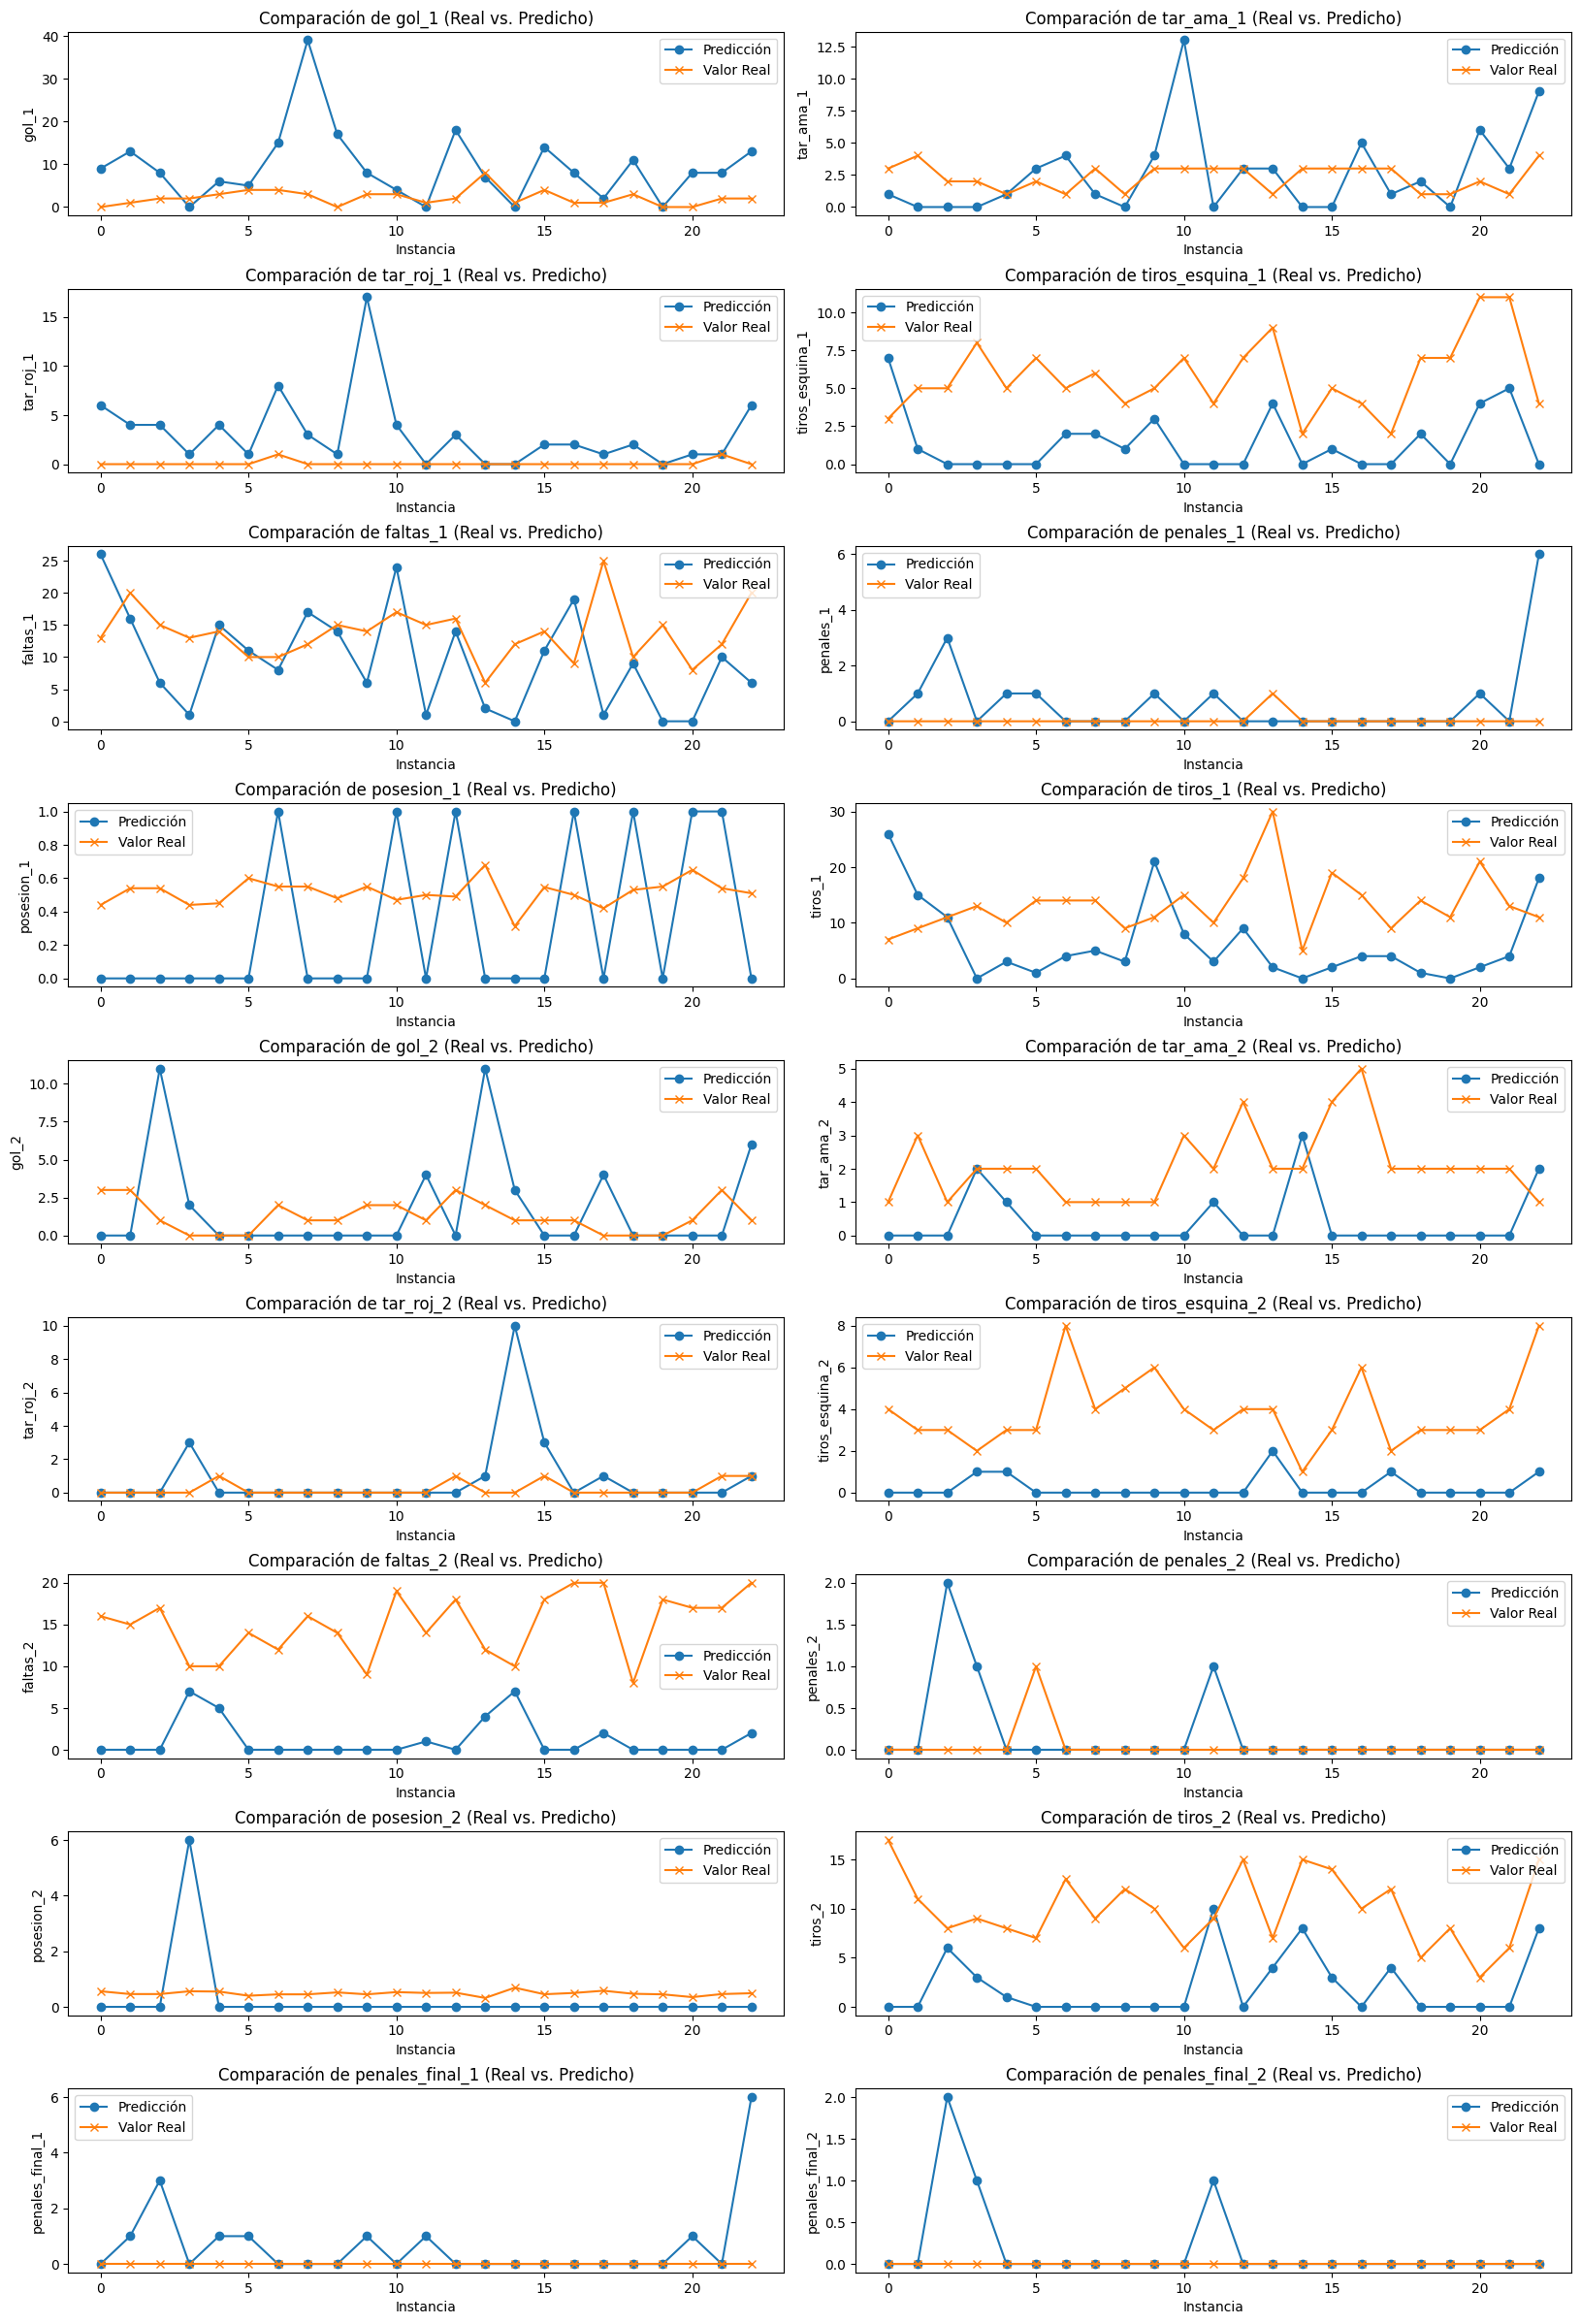

In [60]:
n = 2
fig, axs = plt.subplots(int(df_combined_stats.shape[1]/n), n, figsize=(20, 30))

for i, col in enumerate(df_combined_stats.columns):

  # Graficar valores reales y predicciones
  axs[int(i/n), i%n].plot(df_combined_stats[col], label='Predicción', marker='o')
  axs[int(i/n), i%n].plot(test[col], label='Valor Real', marker='x')

    # Configurar título, etiquetas y leyenda
  axs[int(i/n), i%n].set_title(f'Comparación de {df_combined_stats.columns[i]} (Real vs. Predicho)')
  axs[int(i/n), i%n].set_xlabel('Instancia')
  axs[int(i/n), i%n].set_ylabel(f'{df_combined_stats.columns[i]}')
  axs[int(i/n), i%n].legend()

  axs[int(i/n), i%n].legend()

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()

## LSTM base sin Lematización ni stemming. Narración base limpia

In [63]:
# Tokenización del texto
tokenizer2 = Tokenizer(num_words=10000)
tokenizer2.fit_on_texts(train_data['Cleaned_Subtitles'])

train_sequences = tokenizer2.texts_to_sequences(train_data['Cleaned_Subtitles'])
test_sequences = tokenizer2.texts_to_sequences(test_data['Cleaned_Subtitles'])

# Rellenamos las secuencias para que tengan la misma longitud
X_train_c = pad_sequences(train_sequences, maxlen=maxlen)
X_test_c = pad_sequences(test_sequences, maxlen=maxlen)

# Convertimos las etiquetas en arrays
y_train_c = train_data['Simplified_Labels']
y_test_c = test_data['Simplified_Labels']

# Definimos el modelo LSTM con dropout
model_c = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
    tf.keras.layers.LSTM(256, return_sequences=False),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout después de la LSTM
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),  # Añadimos dropout antes de la capa final
    tf.keras.layers.Dense(7, activation='softmax')  # 7 clases de eventos
])

# Compilamos el modelo
model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definimos EarlyStopping para detener el entrenamiento cuando el modelo deja de mejorar
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamos el modelo con más épocas y early stopping
history = model_c.fit(X_train_c, y_train_c,
                    epochs=300,  # Aumentamos las épocas
                    validation_data=(X_test_c, y_test_c),
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 867ms/step - accuracy: 0.3685 - loss: 1.9413 - val_accuracy: 0.9565 - val_loss: 1.8607
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 833ms/step - accuracy: 0.9890 - loss: 1.7927 - val_accuracy: 0.9565 - val_loss: 0.6675
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9656 - loss: 0.3990 - val_accuracy: 0.9565 - val_loss: 0.4359
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9890 - loss: 0.1785 - val_accuracy: 0.9565 - val_loss: 0.5561
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 696ms/step - accuracy: 0.9773 - loss: 0.3007 - val_accuracy: 0.9565 - val_loss: 0.4695
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step - accuracy: 0.9773 - loss: 0.2546 - val_accuracy: 0.9565 - val_loss: 0.3547
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step - accuracy: 0.9812 - loss: 0.1437 - val_accuracy: 0.9565 - val_loss: 0.2592
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 750ms/step - accuracy: 0.9851 - loss: 0.1074 - val_accuracy: 0.9565 - val_loss: 0.1955
Ep

In [67]:
# Aplicamos el modelo a nuevas narraciones
predictions2 = model_c.predict(X_test)

# Crear listas para almacenar las estadísticas y predicciones
matches_stats = []

# Generar estadísticas para todas las narraciones de prueba
for i in range(len(test_data)):  # Recorremos todas las narraciones
    narration = test_data['Cleaned_Subtitles'].iloc[i]
    event_prediction = prediction_to_event(predictions2[i])
    team1_stats, team2_stats = assign_events_to_teams(narration)

    # Crear un diccionario con los datos de la narración actual
    match_stats = {
        'Narration': narration,
        'Predicted_Event': event_prediction,
        'Team1_Stats': team1_stats,
        'Team2_Stats': team2_stats
    }

    # Agregar el diccionario a la lista
    matches_stats.append(match_stats)

# Convertir la lista de diccionarios en un DataFrame
df_matches_stats = pd.DataFrame(matches_stats)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


In [68]:
team1_stats_list = df_matches_stats['Team1_Stats']
team2_stats_list = df_matches_stats['Team2_Stats']

# Crear dataframes separados para Team1_Stats y Team2_Stats
df_team1 = pd.DataFrame(team1_stats_list.tolist()).rename(columns={
    'Tarjetas Amarillas': 'tar_ama_1',
    'Tarjetas Rojas': 'tar_roj_1',
    'Tiros de Esquina': 'tiros_esquina_1',
    'Goles': 'gol_1',
    'Atajadas': 'atajadas_1',
    'Posesión de balón': 'posesion_1',
    'Faltas': 'faltas_1',
    'Tiros': 'tiros_1',
    'Penales': 'penales_1'
})

df_team2 = pd.DataFrame(team2_stats_list.tolist()).rename(columns={
    'Tarjetas Amarillas': 'tar_ama_2',
    'Tarjetas Rojas': 'tar_roj_2',
    'Tiros de Esquina': 'tiros_esquina_2',
    'Goles': 'gol_2',
    'Atajadas': 'atajadas_2',
    'Posesión de balón': 'posesion_2',
    'Faltas': 'faltas_2',
    'Tiros': 'tiros_2',
    'Penales': 'penales_2'
})

df_combined_stats = pd.concat([df_team1, df_team2], axis=1)

# Añadir las columnas de penales finales, si es necesario
df_combined_stats['penales_final_1'] = df_combined_stats['penales_1']
df_combined_stats['penales_final_2'] = df_combined_stats['penales_2']
df_combined_stats = df_combined_stats.drop(columns=['Saques de Banda', 'Fueras de juego'])

df_combined_stats.head()

gol_1  tar_ama_1  tar_roj_1  tiros_esquina_1  faltas_1  penales_1  \
0      9          1          6                7        26          0   
1     13          0          4                1        16          1   
2      8          0          4                0         6          3   
3      0          0          1                0         1          0   
4      6          1          4                0        15          1   

   posesion_1  tiros_1  gol_2  tar_ama_2  tar_roj_2  tiros_esquina_2  \
0           0       26      0          0          0                0   
1           0       15      0          0          0                0   
2           0       11     11          0          0                0   
3           0        0      2          2          3                1   
4           0        3      0          1          0                1   

   faltas_2  penales_2  posesion_2  tiros_2  penales_final_1  penales_final_2  
0         0          0           0        0                0                0  
1         0          0           0        0                1                0  
2         0          2           0        6                3                2  
3         7          1           6        3                0                1  
4         5          0           0        1                1                0

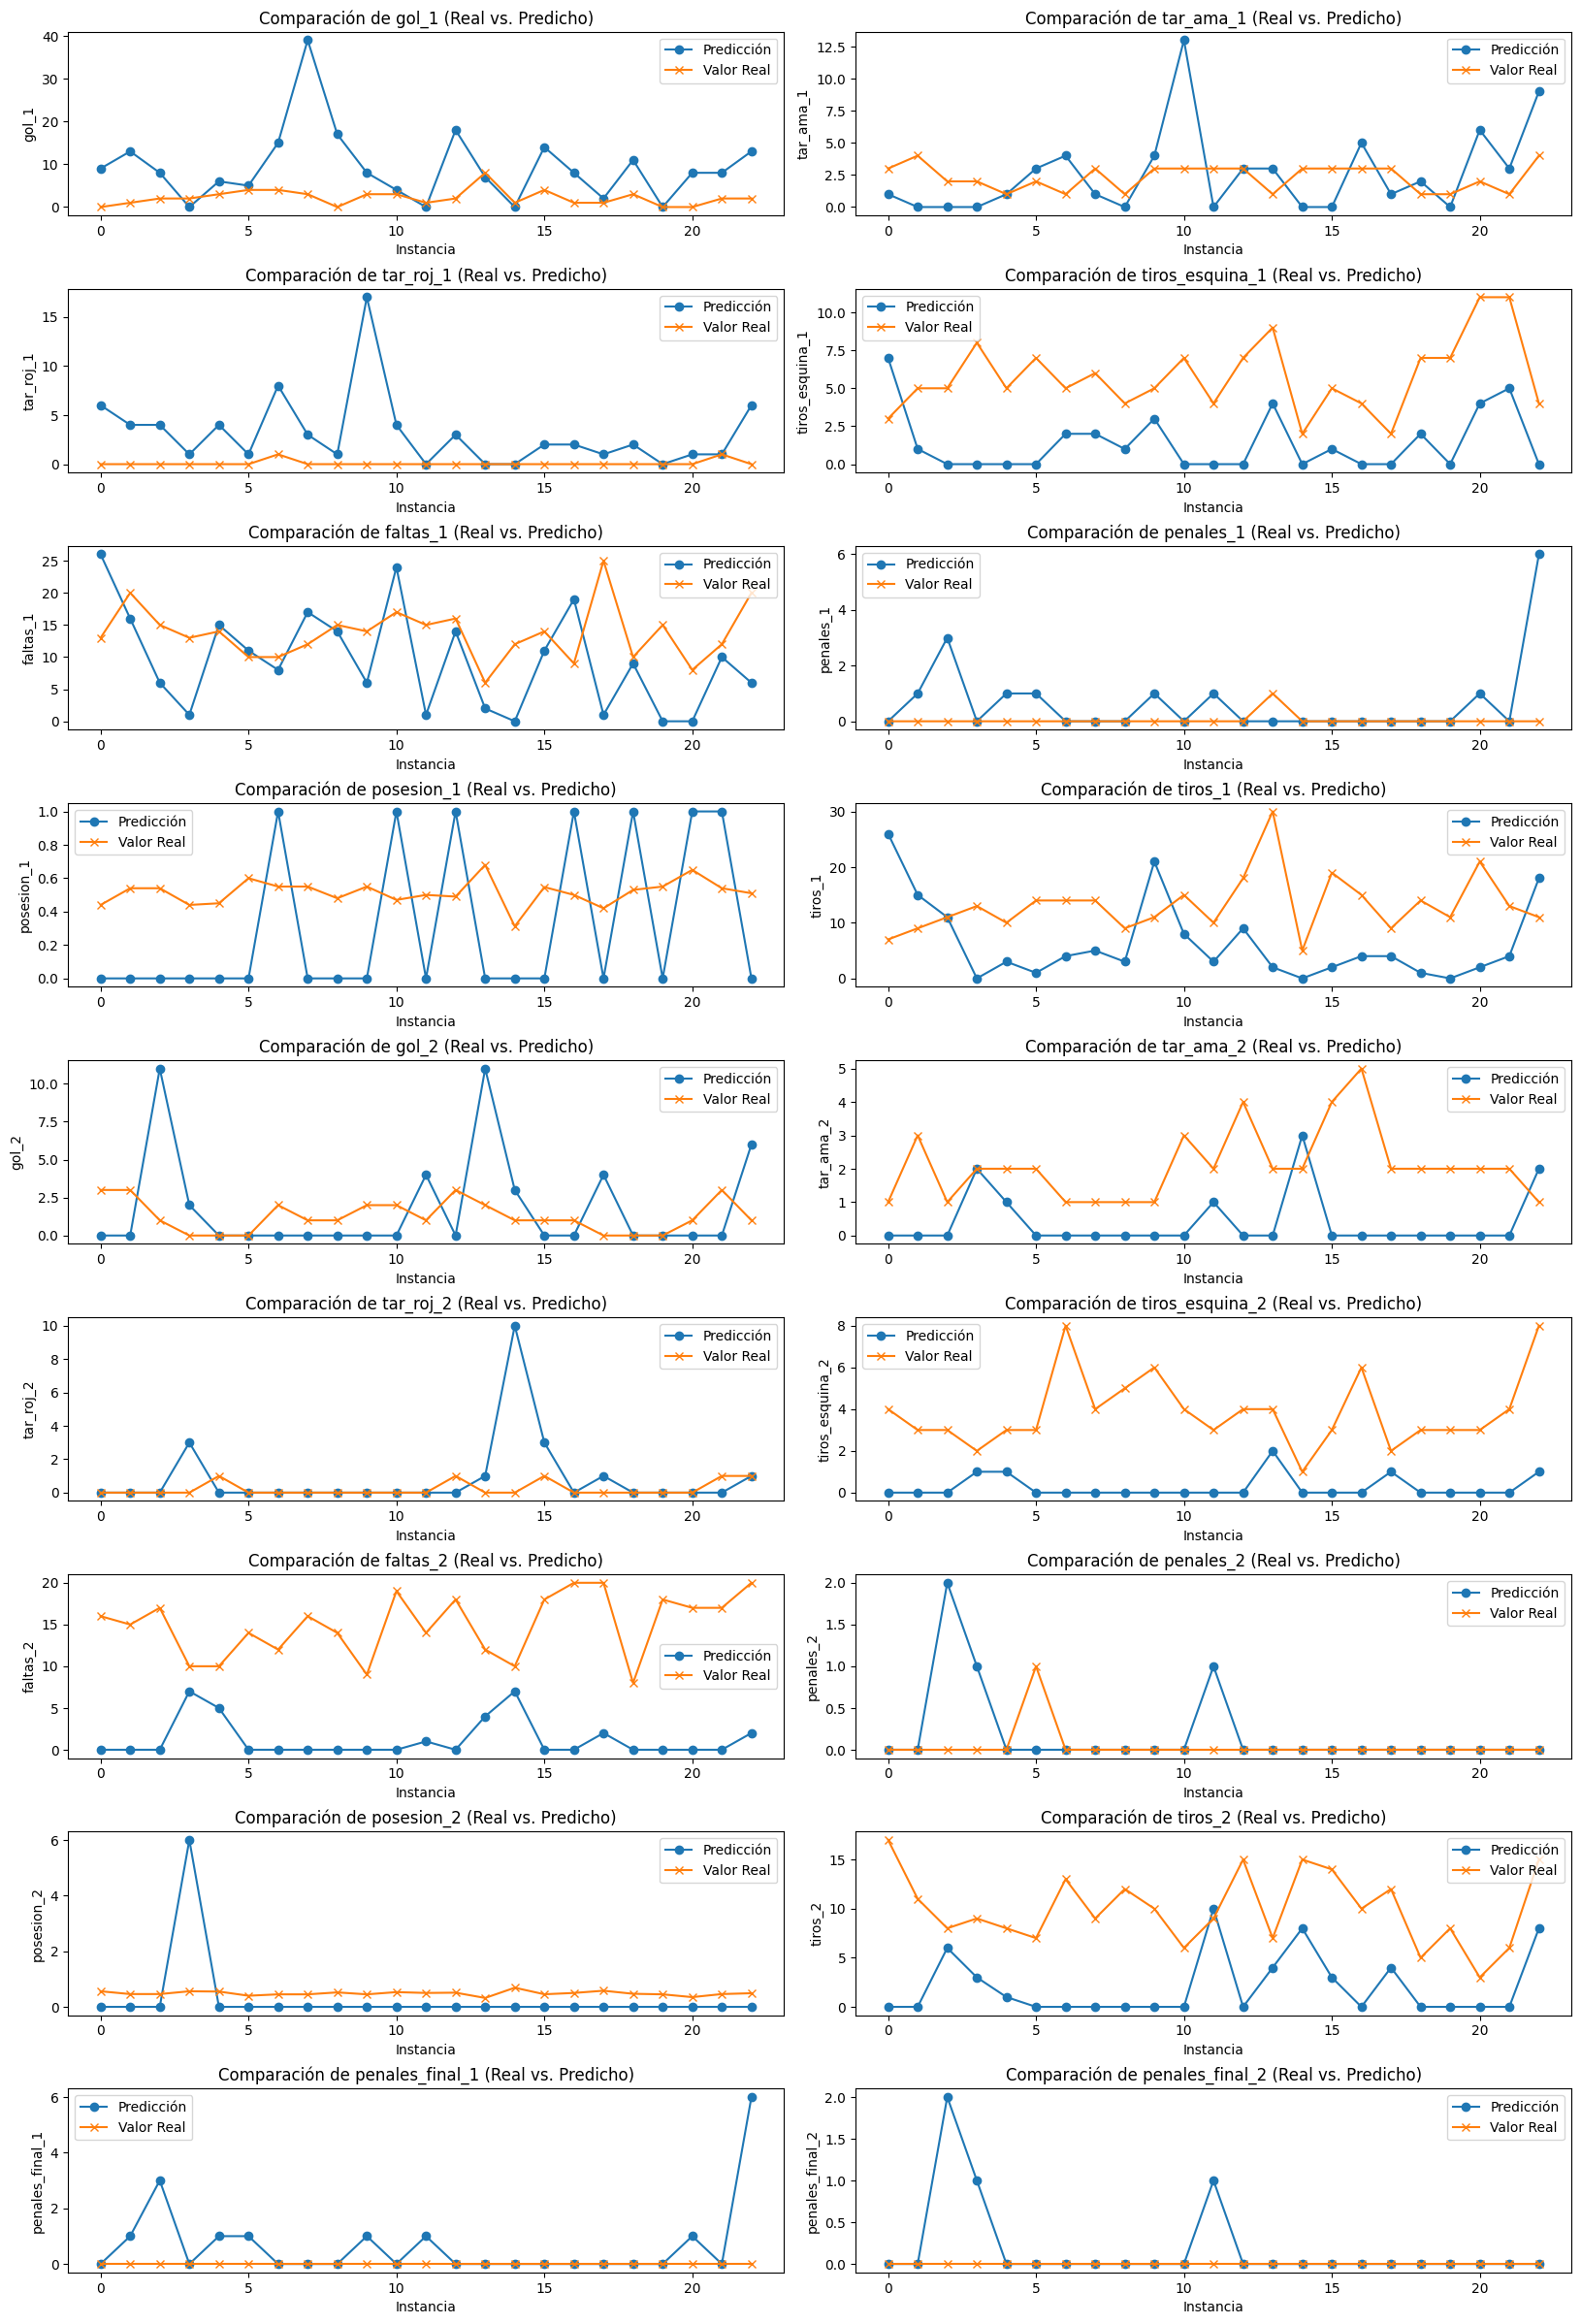

In [69]:
n = 2
fig, axs = plt.subplots(int(df_combined_stats.shape[1]/n), n, figsize=(20, 30))

for i, col in enumerate(df_combined_stats.columns):

  # Graficar valores reales y predicciones
  axs[int(i/n), i%n].plot(df_combined_stats[col], label='Predicción', marker='o')
  axs[int(i/n), i%n].plot(test[col], label='Valor Real', marker='x')

    # Configurar título, etiquetas y leyenda
  axs[int(i/n), i%n].set_title(f'Comparación de {df_combined_stats.columns[i]} (Real vs. Predicho)')
  axs[int(i/n), i%n].set_xlabel('Instancia')
  axs[int(i/n), i%n].set_ylabel(f'{df_combined_stats.columns[i]}')
  axs[int(i/n), i%n].legend()

  axs[int(i/n), i%n].legend()

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()

## TF-IDF LSTM

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [75]:
# Definimos EarlyStopping para detener el entrenamiento cuando el modelo deja de mejorar
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# Vectorización con TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limitar a las 500 características más relevantes
X_tfidf = tfidf_vectorizer.fit_transform(df['lemmatized_Subtitles']).toarray()

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)

# Redimensionar los datos para que sean compatibles con LSTM (agregando una dimensión)
X_train_lstm = np.expand_dims(X_train, axis=-1)
X_test_lstm = np.expand_dims(X_test, axis=-1)

In [76]:
model = Sequential([
    LSTM(128, input_shape=(X_train_lstm.shape[1], 1), return_sequences=False),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout después de la LSTM
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout antes de la capa final
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout antes de la capa final
    Dense(Y.shape[1], activation='linear')
])


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_lstm,
          y_train,
          epochs=100,
          batch_size=32,
          validation_data=(X_test_lstm, y_test),
          callbacks=[early_stopping]
          )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.0775 - loss: 48.7427 - val_accuracy: 0.0870 - val_loss: 43.0096
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - accuracy: 0.1292 - loss: 47.5722 - val_accuracy: 0.0870 - val_loss: 42.7486
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - accuracy: 0.2074 - loss: 46.9801 - val_accuracy: 0.0870 - val_loss: 41.0392
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step - accuracy: 0.1245 - loss: 43.8034 - val_accuracy: 0.0870 - val_loss: 33.2550
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - accuracy: 0.1425 - loss: 37.2838 - val_accuracy: 0.0870 - val_loss: 26.6733
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1856 - loss: 30.7825 - val_accuracy: 0.0870 - val_loss: 20.3178
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 568ms/step - accuracy: 0.2356 - loss: 25.0187 - val_accuracy: 0.3478 - val_loss: 14.7209
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - accuracy: 0.2858 - loss: 21.9649 - val_accuracy: 0.3478 - val_

In [78]:
y_pred = model.predict(X_test_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


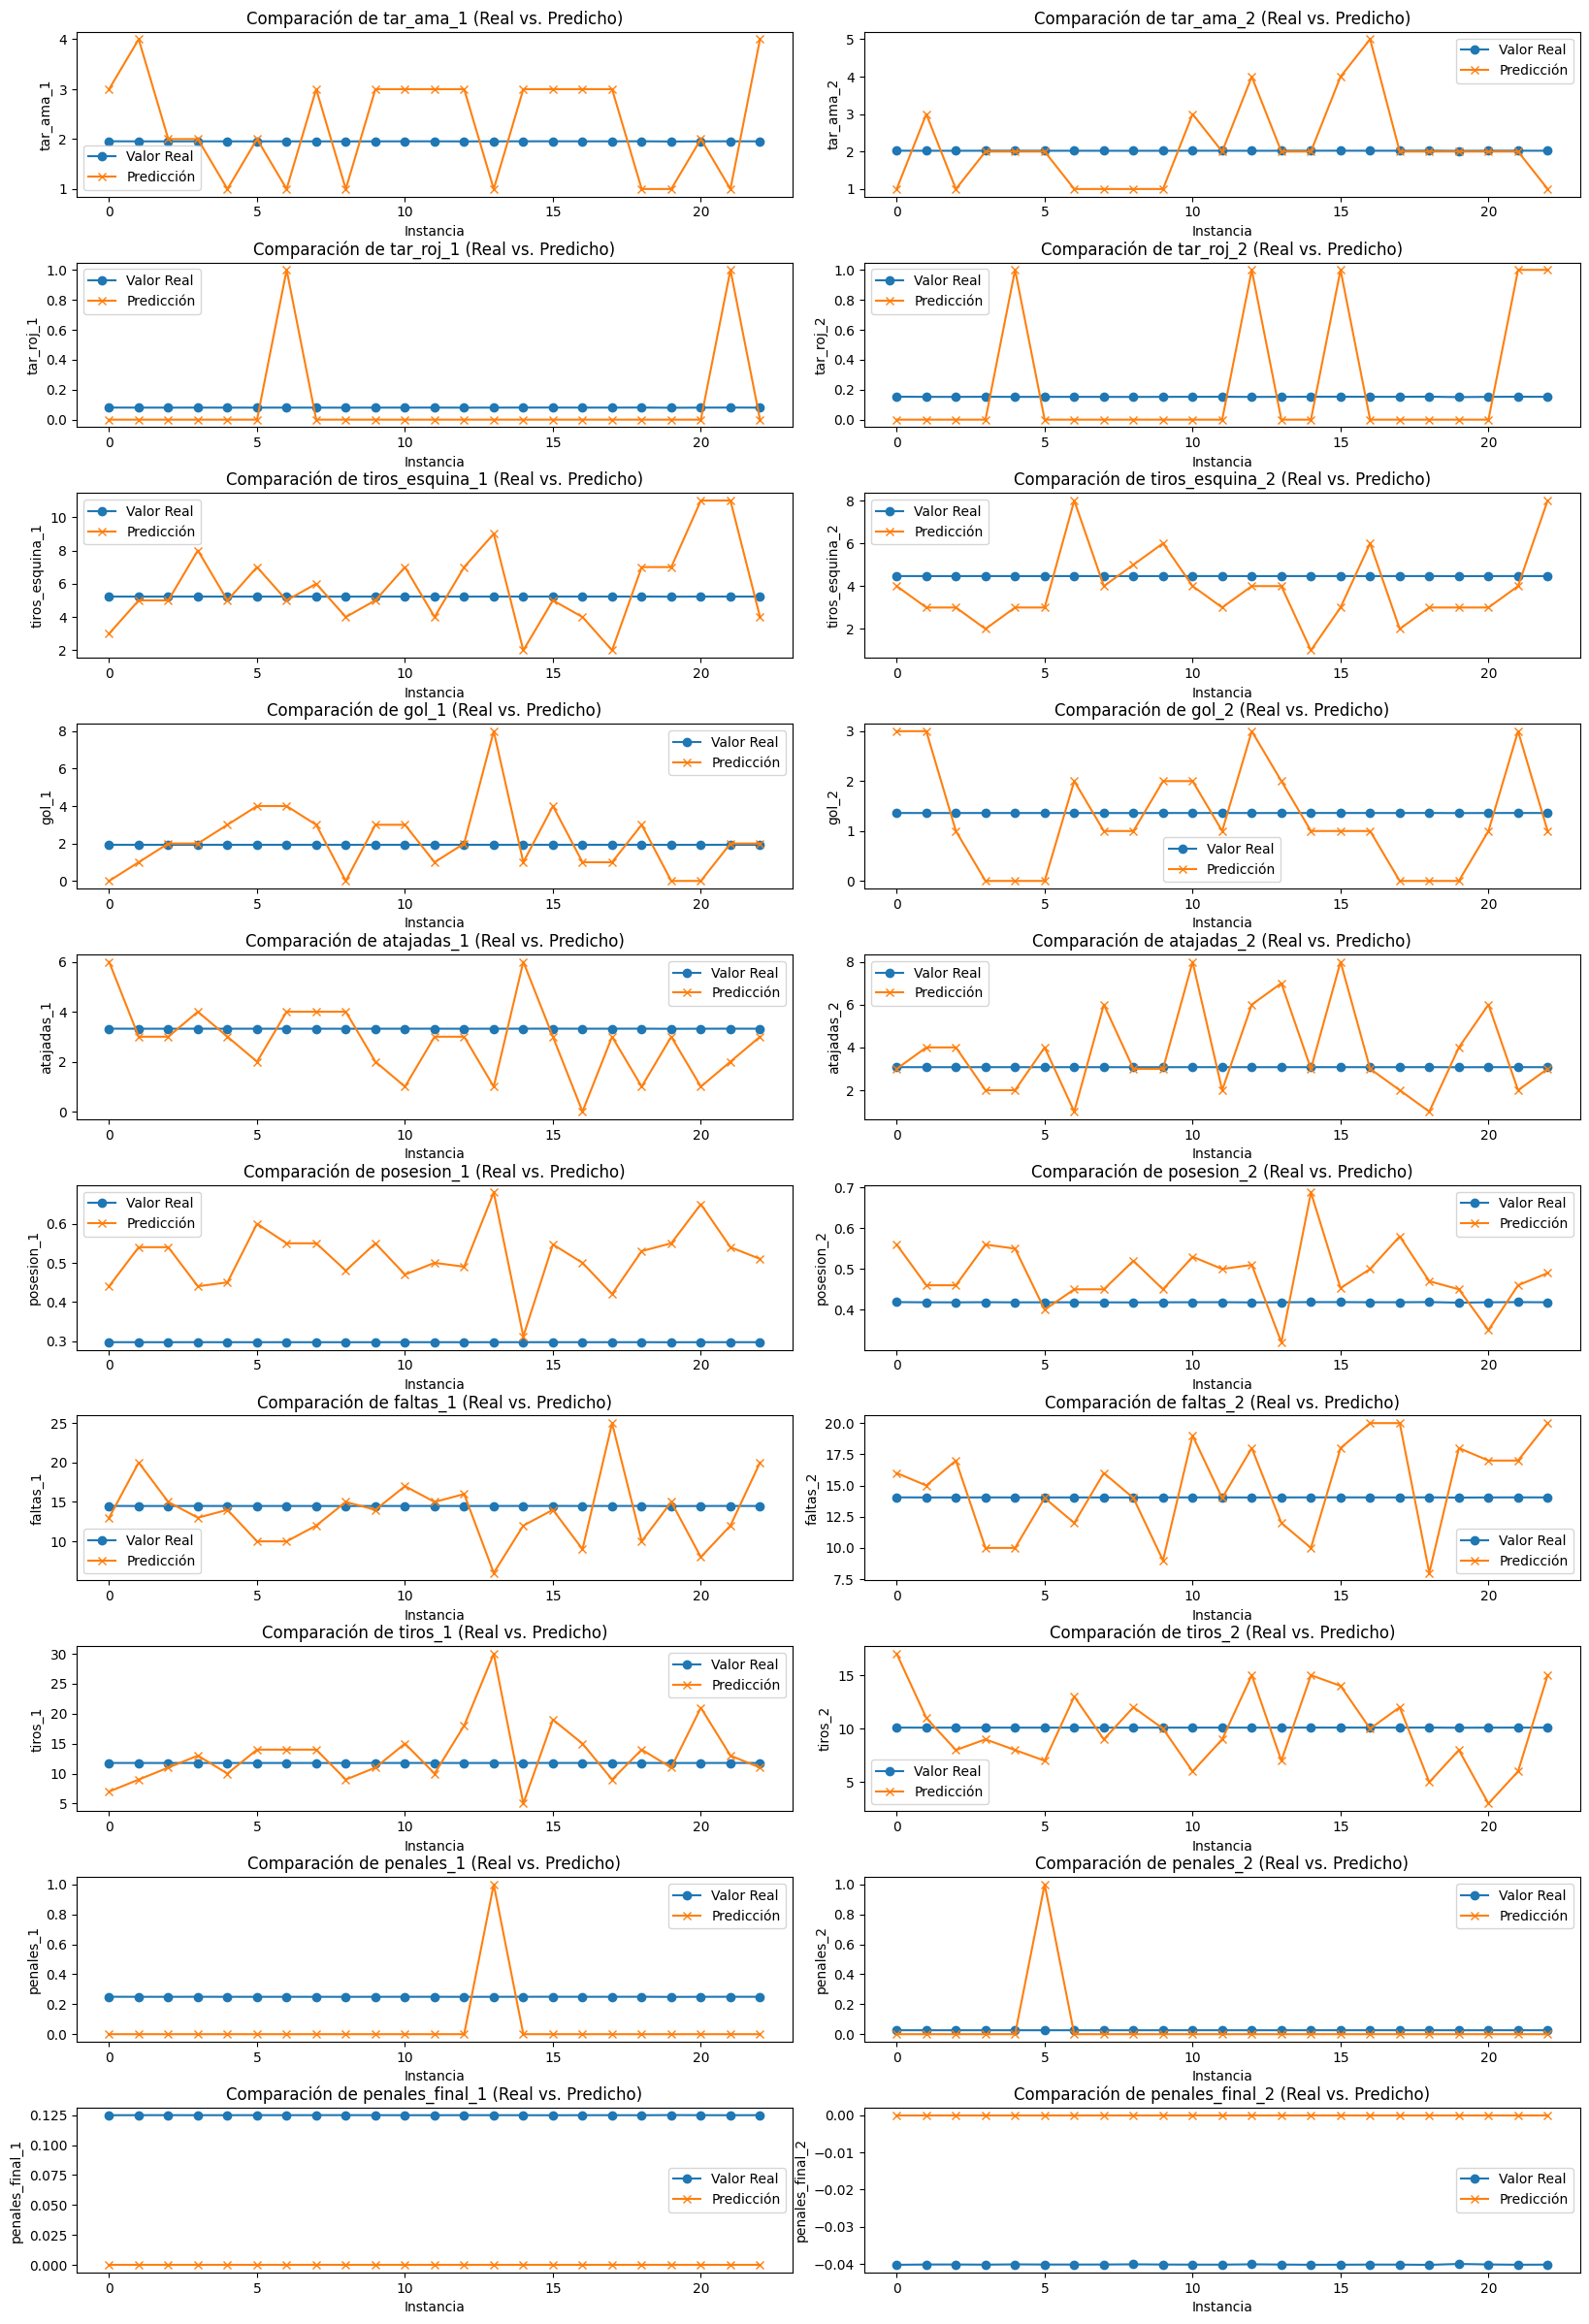

In [81]:
test =  y_test.reset_index(drop=True)
n = 2
fig, axs = plt.subplots(int(test.shape[1]/n), n, figsize=(20, 30))

for i in range(test.shape[1]):

  # Graficar valores reales y predicciones
  axs[int(i/n), i%n].plot(y_pred[:, i], label='Valor Real', marker='o')
  axs[int(i/n), i%n].plot(test.iloc[:, i], label='Predicción', marker='x')

    # Configurar título, etiquetas y leyenda
  axs[int(i/n), i%n].set_title(f'Comparación de {test.columns[i]} (Real vs. Predicho)')
  axs[int(i/n), i%n].set_xlabel('Instancia')
  axs[int(i/n), i%n].set_ylabel(f'{test.columns[i]}')
  axs[int(i/n), i%n].legend()

  axs[int(i/n), i%n].legend()

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()

## Conclusiones

### Mejor Modelo

LSTM lemmatizado y texto limpio dieron los mismos resultados.

### Otros Enfoques

BERT